In [15]:
# Import third-party packages.
from imblearn.over_sampling import RandomOverSampler, SMOTE
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings
from xgboost import XGBClassifier

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

In [2]:
# Read in preprocessed data on trees.
df = pd.read_csv('./data/data_preprocessed/features.csv') #, compression='gzip'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10e98fe50>,
      dtype=object)

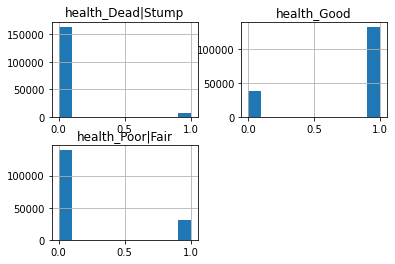

In [10]:
x = df.loc[:, 'steward_Alive':'n_neighbors_two or more neighbors']
y = df.loc[:, 'health_Dead|Stump':]

# Split into training, testing, and validation datasets.
x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                      y,
                                                      test_size=0.5,
                                                      random_state=34,
                                                      shuffle=True,
                                                      stratify=y)

x_training, x_testing, y_training, y_testing = train_test_split(x_train,
                                                                y_train,
                                                                test_size=0.5,
                                                                random_state=34,
                                                                shuffle=True,
                                                                stratify=y_train)

# Check class imbalance of targets.
y_training.hist()

target_first_class = len(y_train.loc[y_train['health_Dead|Stump'] == 0]) / len(y_train)
target_second_class = len(y_train.loc[y_train['health_Fair'] == 0]) / len(y_train)
target_third_class = len(y_train.loc[y_train['health_Good'] == 0]) / len(y_train)
target_fourth_class = len(y_train.loc[y_train['health_Poor'] == 0]) / len(y_train)


class_weight_orig = [{0:target_first_class, 1:1-target_first_class},
                     {0:target_second_class, 1:1-target_second_class},
                     {0:target_third_class, 1:1-target_third_class},
                     {0:target_fourth_class, 1:1-target_fourth_class}]

class_weight_manip = [{0:target_first_class, 1:1-target_first_class},
                      {0:1-target_second_class-0.1, 1:target_second_class+0.1},
                      {0:target_third_class, 1:1-target_third_class},
                      {0:1-target_fourth_class, 1:target_fourth_class}]

print(class_weight_orig)
print(class_weight_manip)

# Oversampling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133d0c130>,
      dtype=object)

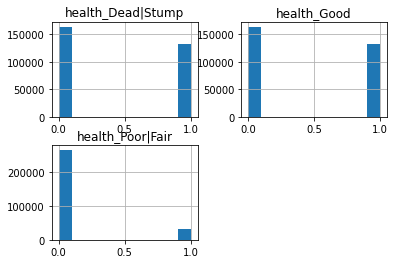

In [11]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=34)

x_training_ros, y_training_ros = ros.fit_resample(x_training.values, y_training.values)

pd.DataFrame(y_training_ros, columns=df.columns[-3:]).hist()

# SMOTE

In [6]:
df_poorfair = df.loc[(df['health_Poor|Fair']==1) | (df_new['health_Dead|Stump']==0)].copy().reindex()

x_pf = df_poorfair.loc[:, 'steward_Alive':'n_neighbors_two or more neighbors']
y_pf = df_poorfair.loc[:, 'health_Dead|Stump':]

x_train_pf, x_test_pf, y_train_pf, y_test_pf = train_test_split(x_pf,
                                                                y_pf,
                                                                test_size=0.5,
                                                                random_state=34,
                                                                stratify=y_pf)

NameError: name 'df_new' is not defined

# Modelling

In [ ]:
# Enlist classifiers and their default parameters.
classifiers = {
    'xgb': XGBClassifier(n_estimators=100,
                         objective='binary:logistic',
                         max_depth=8,
                         learning_rate=0.1,
                         verbosity=None,
                         booster=None,
                         tree_method=None,
                         gamma=1,
                         min_child_weight=None,
                         max_delta_step=None,
                         subsample=0.8,
                         colsample_bytree=None,
                         colsample_bylevel=None,
                         colsample_bynode=None,
                         reg_alpha=None,
                         reg_lambda=None,
                         scale_pos_weight=None,
                         base_score=None,
                         num_parallel_tree=None,
                         random_state=34,
                         n_jobs=-1,
                         monotone_constraints=None,
                         interaction_constraints=None,
                         importance_type='gain',
                         validate_parameters=None),
    'ada': AdaBoostClassifier(base_estimator=None,
                              n_estimators=50,
                              learning_rate=1.0,
                              random_state=34,
                              algorithm='SAMME.R'),
    
}

In [32]:
AdaBoostClassifier().__dict__

{'base_estimator': None,
 'n_estimators': 50,
 'estimator_params': (),
 'learning_rate': 1.0,
 'random_state': None,
 'algorithm': 'SAMME.R'}

In [8]:
# Run the XGBClassifier with default parameter settings.
xgb_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    xgb_clfs[each] = {
                'trained_classifier': XGBClassifier(learning_rate=0.1,
                                                    gamma=1,
                                                    n_estimators=3000,
                                                    max_depth=8,
                                                    subsample=0.8,
                                                    random_state=34,
                                                    nthread=-1) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    xgb_clfs[each]['predictions'] = xgb_clfs[each]['trained_classifier'].predict(x_testing.values)
    xgb_clfs[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                xgb_clfs[each]['predictions'])
    
    print(each, ': ', xgb_clfs[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], xgb_clfs[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], xgb_clfs[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], xgb_clfs[each]['predictions'], average='binary'))

KeyboardInterrupt: 

In [44]:
# Run the AdaBoostClassifier with default parameter settings.
ada_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    ada_clfs[each] = {
                'trained_classifier': AdaBoostClassifier(learning_rate=1.0,
                                                         algorithm='SAMME.R',
                                                         n_estimators=50,
                                                         random_state=34) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    ada_clfs[each]['predictions'] = ada_clfs[each]['trained_classifier'].predict(x_testing.values)
    ada_clfs[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                ada_clfs[each]['predictions'])
    
    print(each, ': ', ada_clfs[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], ada_clfs[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], ada_clfs[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], ada_clfs[each]['predictions'], average='binary'))

health_Dead|Stump :  0.9999958215989905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228261
           1       1.00      1.00      1.00     11065

    accuracy                           1.00    239326
   macro avg       1.00      1.00      1.00    239326
weighted avg       1.00      1.00      1.00    239326

0.9999138033445251
f1_score: 0.9999548104297528
health_Good :  0.8215822768942781
              precision    recall  f1-score   support

           0       0.92      0.23      0.37     54228
           1       0.82      0.99      0.90    185098

    accuracy                           0.82    239326
   macro avg       0.87      0.61      0.63    239326
weighted avg       0.84      0.82      0.78    239326

0.8154654107101259
f1_score: 0.8960073647243343
health_Poor|Fair :  0.8215864552952876
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    196163
           1       0.58     

In [45]:
# Run the RandomForestClassifier with default parameter settings.
rdf_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    rdf_clfs[each] = {
                'trained_classifier': RandomForestClassifier(n_estimators=100,
                                                             random_state=34,
                                                             max_depth=None,
                                                             max_samples=None,
                                                             min_samples_split=2,
                                                             min_samples_leaf=1,
                                                             min_weight_fraction_leaf=0.0,
                                                             max_features='auto',
                                                             max_leaf_nodes=None,
                                                             min_impurity_decrease=0.0,
                                                             oob_score=False,
                                                             bootstrap=True,
                                                             n_jobs=-1,
                                                             verbose=1,
                                                             warm_start=False,
                                                             class_weight=None,
                                                             ccp_alpha=0.0) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    rdf_clfs[each]['predictions'] = rdf_clfs[each]['trained_classifier'].predict(x_testing.values)
    rdf_clfs[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                rdf_clfs[each]['predictions'])
    
    print(each, ': ', rdf_clfs[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], rdf_clfs[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], rdf_clfs[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], rdf_clfs[each]['predictions'], average='binary'))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


health_Dead|Stump :  0.9999958215989905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228261
           1       1.00      1.00      1.00     11065

    accuracy                           1.00    239326
   macro avg       1.00      1.00      1.00    239326
weighted avg       1.00      1.00      1.00    239326

0.9999138033445251
f1_score: 0.9999548104297528


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


health_Good :  0.8211101175802044
              precision    recall  f1-score   support

           0       0.91      0.23      0.37     54228
           1       0.82      0.99      0.90    185098

    accuracy                           0.82    239326
   macro avg       0.86      0.61      0.63    239326
weighted avg       0.84      0.82      0.78    239326

0.8153325018108686
f1_score: 0.895706507837907


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


health_Poor|Fair :  0.8210892255751568
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    196163
           1       0.56      0.04      0.07     43163

    accuracy                           0.82    239326
   macro avg       0.69      0.52      0.49    239326
weighted avg       0.78      0.82      0.75    239326

0.19444098176209995
f1_score: 0.06953800686687818


In [46]:
from sklearn.linear_model import RidgeClassifier

# Try algs.
log_regr = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    log_regr[each] = {
                'trained_classifier': RidgeClassifier() \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    log_regr[each]['predictions'] = log_regr[each]['trained_classifier'].predict(x_testing.values)
    log_regr[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                log_regr[each]['predictions'])
    
    print(each, ': ', log_regr[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], log_regr[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], log_regr[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], log_regr[each]['predictions'], average='binary'))

health_Dead|Stump :  0.9999958215989905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228261
           1       1.00      1.00      1.00     11065

    accuracy                           1.00    239326
   macro avg       1.00      1.00      1.00    239326
weighted avg       1.00      1.00      1.00    239326

0.9999138033445251
f1_score: 0.9999548104297528
health_Good :  0.8216742017164871
              precision    recall  f1-score   support

           0       0.92      0.23      0.37     54228
           1       0.82      0.99      0.90    185098

    accuracy                           0.82    239326
   macro avg       0.87      0.61      0.63    239326
weighted avg       0.84      0.82      0.78    239326

0.8153708267690787
f1_score: 0.8960897935333074
health_Poor|Fair :  0.8216783801174966
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    196163
           1       0.59     

In [12]:
from sklearn.neural_network import MLPClassifier

# Try algs.
mlp_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    mlp_clfs[each] = {
                'trained_classifier': MLPClassifier() \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    mlp_clfs[each]['predictions'] = mlp_clfs[each]['trained_classifier'].predict(x_testing.values)
    mlp_clfs[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                mlp_clfs[each]['predictions'])
    
    print(each, ': ', mlp_clfs[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], mlp_clfs[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], mlp_clfs[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], mlp_clfs[each]['predictions'], average='binary'))

health_Dead|Stump :  0.9999958215989905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228261
           1       1.00      1.00      1.00     11065

    accuracy                           1.00    239326
   macro avg       1.00      1.00      1.00    239326
weighted avg       1.00      1.00      1.00    239326

0.9999138033445251
f1_score: 0.9999548104297528
health_Good :  0.8217619481376867
              precision    recall  f1-score   support

           0       0.93      0.23      0.37     54228
           1       0.82      0.99      0.90    185098

    accuracy                           0.82    239326
   macro avg       0.87      0.61      0.63    239326
weighted avg       0.84      0.82      0.78    239326

0.8151910036133663
f1_score: 0.8961861674036685
health_Poor|Fair :  0.8216198825033636
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    196163
           1       0.59     

In [48]:
from sklearn.svm import LinearSVC

# Try algs.
log_regr = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    log_regr[each] = {
                'trained_classifier': LinearSVC() \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    log_regr[each]['predictions'] = log_regr[each]['trained_classifier'].predict(x_testing.values)
    log_regr[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                log_regr[each]['predictions'])
    
    print(each, ': ', log_regr[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], log_regr[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], log_regr[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], log_regr[each]['predictions'], average='binary'))

health_Dead|Stump :  0.9999958215989905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228261
           1       1.00      1.00      1.00     11065

    accuracy                           1.00    239326
   macro avg       1.00      1.00      1.00    239326
weighted avg       1.00      1.00      1.00    239326

0.9999138033445251
f1_score: 0.9999548104297528
health_Good :  0.8216825585185061
              precision    recall  f1-score   support

           0       0.92      0.23      0.37     54228
           1       0.82      0.99      0.90    185098

    accuracy                           0.82    239326
   macro avg       0.87      0.61      0.63    239326
weighted avg       0.84      0.82      0.78    239326

0.8153831217665312
f1_score: 0.8960931451082749
health_Poor|Fair :  0.8216867369195157
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    196163
           1       0.59     

In [16]:
# Run LGBMClassifier with default parameter settings.
lgbm_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    lgbm_clfs[each] = {
                'trained_classifier': LGBMClassifier(boosting_type='dart',
                                                     num_leaves=100,
                                                     max_depth=-1,
                                                     learning_rate=0.04,
                                                     n_estimators=100,
                                                     subsample_for_bin=200000,
                                                     objective='binary',
                                                     class_weight=None,
                                                     min_split_gain=0.0,
                                                     min_child_weight=1e-3,
                                                     min_child_samples=20,
                                                     subsample=1.0,
                                                     subsample_freq=0,
                                                     colsample_bytree=1.0,
                                                     reg_alpha=0.0,
                                                     reg_lambda=0.0,
                                                     random_state=34,
                                                     n_jobs=-1,
                                                     silent=False,
                                                     importance_type='split') \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    lgbm_clfs[each]['predictions'] = lgbm_clfs[each]['trained_classifier'].predict(x_testing.values)
    lgbm_clfs[each]['accuracy'] = balanced_accuracy_score(y_testing.values[:, ind],
                                                          lgbm_clfs[each]['predictions'])
    
    print(each, ': ', lgbm_clfs[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], lgbm_clfs[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], lgbm_clfs[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], lgbm_clfs[each]['predictions'], average='binary'))
    print(confusion_matrix(y_testing.values[:, ind], lgbm_clfs[each]['predictions']))

health_Dead|Stump :  0.9999367408906883
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    163043
           1       1.00      1.00      1.00      7904

    accuracy                           1.00    170947
   macro avg       1.00      1.00      1.00    170947
weighted avg       1.00      1.00      1.00    170947

0.9998793315476783
f1_score: 0.9999367368887201
[[163043      0]
 [     1   7903]]
health_Good :  0.6178251473996208
              precision    recall  f1-score   support

           0       0.88      0.25      0.38     38734
           1       0.82      0.99      0.90    132213

    accuracy                           0.82    170947
   macro avg       0.85      0.62      0.64    170947
weighted avg       0.83      0.82      0.78    170947

0.8170654198036122
f1_score: 0.8955720125194547
[[  9510  29224]
 [  1305 130908]]
health_Poor|Fair :  0.5211800271795006
              precision    recall  f1-score   support

           0

In [30]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier

tes = MultiOutputClassifier(MLPClassifier()).fit(x_training_ros, y_training_ros)

preds = tes.predict(x_testing.values)
acc = accuracy_score(y_testing.values, preds)

print(acc)
print(classification_report(y_testing.values, preds, target_names=y.columns))
print(average_precision_score(y_testing.values, preds, average='weighted'))

0.8177388313336882
                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00      7904
      health_Good       0.82      0.99      0.90    132213
 health_Poor|Fair       0.55      0.05      0.10     30830

        micro avg       0.82      0.82      0.82    170947
        macro avg       0.79      0.68      0.66    170947
     weighted avg       0.78      0.82      0.76    170947
      samples avg       0.82      0.82      0.82    170947

0.7128446791359935


In [ ]:
tes = np.array([[1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0]])

tes = pd.Series([1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0])

def classify_tree(tree, classifiers, targets):
    # tree = np.array([[1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0]])
    # classifiers = xgb_clfs
    # targets = y

    results = {
        each: classifiers[each]['trained_classifier'].predict(tree)
        for each in targets.columns
        }

    if (int(sum(results.values())) == 0) | (int(sum(results.values())) > 1):
        print("This tree cannot be classified.")
    else:
        if int(results['health_Dead|Stump']) == 1:
            message = "This is a dead or stump tree."
        elif int(results['health_Good']) == 1:
            message = "This is a healthy tree."
        else:
            message = "This is a tree in a poor or fair health condition."
            
    return results, message

a, c = classify_tree(tes, xgb_clfs, y)

In [65]:
target_first_class = len(y_train_smote[:, 0][y_train_smote[:, 0] == 0]) / len(y_train_smote)
target_second_class = len(y_train_smote[:, 1][y_train_smote[:, 1] == 0]) / len(y_train_smote)
target_third_class = len(y_train_smote[:, 2][y_train_smote[:, 2] == 0]) / len(y_train_smote)

class_weight_orig = [{0:target_first_class, 1:1-target_first_class},
                     {0:target_second_class, 1:1-target_second_class},
                     {0:target_third_class, 1:1-target_third_class}]

class_weight_manip = [{0:0.2, 1:0.8},
                      {0:0.2, 1:0.8},
                      {0:0.2, 1:0.8}]

print(class_weight_orig)
print(class_weight_manip)

[{0: 0.6666666666666666, 1: 0.33333333333333337}, {0: 0.6666666666666666, 1: 0.33333333333333337}, {0: 0.6666666666666666, 1: 0.33333333333333337}]
[{0: 0.2, 1: 0.8}, {0: 0.2, 1: 0.8}, {0: 0.2, 1: 0.8}]


In [75]:
rdf_clf = RandomForestClassifier(class_weight=class_weight_manip, n_jobs=-1)

rdf_clf.fit(x_train_ros, y_train_ros)
y_pred = rdf_clf.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.8228047289510784


# Hyperparameter tuning

In [8]:
parameter_grid = [
      #{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                  {
               'learning_rate': [0.1, 0.5, 0.8],
               'n_estimators': [300, 1000, 3000, 5000]
               }
             ]

default_parameters = {'boosting_type': 'dart',
                      'num_leaves': 31,
                      'max_depth': -1,
                      'learning_rate': 0.1,
                      'n_estimators': 100,
                      'subsample_for_bin': 200000,
                      'objective': 'binary',
                      'class_weight': None,
                      'min_split_gain': 0.2,
                      'min_child_weight': 1e-3,
                      'min_child_samples': 20,
                      'subsample': 1.0,
                      'subsample_freq': 0,
                      'colsample_bytree': 1.0,
                      'reg_alpha': 0.0,
                      'reg_lambda': 0.0,
                      'random_state': 34,
                      'n_jobs': -1,
                      'silent': True,
                      'importance_type': 'split'}

gridsearch_lgbm_clfs = {}

for each, val in lgbm_clfs.items():
    
    ind = list(y.columns).index(each)
    
    print('######### START HYPERPARAMETER TUNING FOR TARGET:', each, '###########################')
    
    gridsearch_lgbm_clfs[each] = {
                        'classifier': GridSearchCV(estimator=val['trained_classifier'],
                                                             param_grid=parameter_grid,
                                                             cv=5,
                                                             scoring='f1',
                                                             refit=True,
                                                             verbose=0,
                                                             error_score=0,
                                                             return_train_score=False,
                                                             n_jobs=-1) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind],
                                          verbose=0)
                        }
    
    print('F1 score: ', gridsearch_lgbm_clfs[each]['classifier'].best_score_)
    
    # Update the set of default parameters.
    default_parameters['learning_rate'] = gridsearch_lgbm_clfs[each]['classifier'].best_params_['learning_rate']
    default_parameters['n_estimators'] = gridsearch_lgbm_clfs[each]['classifier'].best_params_['n_estimators']    
    
    print('Updated parameter setting: ')
    gridsearch_lgbm_clfs[each]['best_params'] = default_parameters
    print(default_parameters)
    print('######### FINISH #####################################################################')

######### START HYPERPARAMETER TUNING FOR TARGET: health_Dead|Stump ###########################
F1 score:  1.0
Updated parameter setting: 
{'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample_for_bin': 200000, 'objective': 'binary', 'class_weight': None, 'min_split_gain': 0.2, 'min_child_weight': 0.001, 'min_child_samples': 20, 'subsample': 1.0, 'subsample_freq': 0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'random_state': 34, 'n_jobs': -1, 'silent': True, 'importance_type': 'split'}
######### FINISH #####################################################################
######### START HYPERPARAMETER TUNING FOR TARGET: health_Good ###########################
F1 score:  0.913399874894079
Updated parameter setting: 
{'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample_for_bin': 200000, 'objective': 'binary', 'class_weight': None, 'min_split_gain':

KeyboardInterrupt: 

In [8]:
parameter_grid = [
      #{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                  {
               'boosting_type': ['dart'],
               'num_leaves': [31, 100, 1000],
               'learning_rate': [0.1, 0.5],
               'n_estimators': [300, 1000, 3000],
               'objective': ['binary'],
               'random_state': [34]
               }
             ]

default_parameters = {'boosting_type': 'dart',
                      'num_leaves': 31,
                      'max_depth': -1,
                      'learning_rate': 0.1,
                      'n_estimators': 100,
                      'subsample_for_bin': 200000,
                      'objective': 'binary',
                      'class_weight': None,
                      'min_split_gain': 0.2,
                      'min_child_weight': 1e-3,
                      'min_child_samples': 20,
                      'subsample': 1.0,
                      'subsample_freq': 0,
                      'colsample_bytree': 1.0,
                      'reg_alpha': 0.0,
                      'reg_lambda': 0.0,
                      'random_state': 34,
                      'n_jobs': -1,
                      'silent': True,
                      'importance_type': 'split'}

gridsearch_lgbm_clfs = {}

for each, val in lgbm_clfs.items():
    
    ind = list(y.columns).index(each)
    
    print('######### START HYPERPARAMETER TUNING FOR TARGET:', each, '###########################')
    
    gridsearch_lgbm_clfs[each] = {
                        'classifier': GridSearchCV(estimator=val['trained_classifier'],
                                                             param_grid=parameter_grid,
                                                             cv=2,
                                                             scoring='f1',
                                                             refit=True,
                                                             verbose=0,
                                                             error_score=0,
                                                             return_train_score=False,
                                                             n_jobs=-1) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind],
                                          verbose=0)
                        }
    
    print('F1 score: ', gridsearch_lgbm_clfs[each]['classifier'].best_score_)
    
    # Update the set of default parameters.
    default_parameters['num_leaves'] = gridsearch_lgbm_clfs[each]['classifier'].best_params_['num_leaves']
    default_parameters['learning_rate'] = gridsearch_lgbm_clfs[each]['classifier'].best_params_['learning_rate']
    default_parameters['n_estimators'] = gridsearch_lgbm_clfs[each]['classifier'].best_params_['n_estimators']    
    
    print('Updated parameter setting: ')
    gridsearch_lgbm_clfs[each]['best_params'] = default_parameters
    print(default_parameters)
    print('######### FINISH #####################################################################')

######### START HYPERPARAMETER TUNING FOR TARGET: health_Dead|Stump ###########################
F1 score:  1.0
Updated parameter setting: 
{'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.1, 'n_estimators': 300, 'subsample_for_bin': 200000, 'objective': 'binary', 'class_weight': None, 'min_split_gain': 0.2, 'min_child_weight': 0.001, 'min_child_samples': 20, 'subsample': 1.0, 'subsample_freq': 0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'random_state': 34, 'n_jobs': -1, 'silent': True, 'importance_type': 'split'}
######### FINISH #####################################################################
######### START HYPERPARAMETER TUNING FOR TARGET: health_Good ###########################
F1 score:  0.8944577019175042
Updated parameter setting: 
{'boosting_type': 'dart', 'num_leaves': 31, 'max_depth': -1, 'learning_rate': 0.5, 'n_estimators': 1000, 'subsample_for_bin': 200000, 'objective': 'binary', 'class_weight': None, 'min_split_gain

In [14]:
parameter_grid = [
                  {
               'activation': ['identity', 'logistic', 'tanh', 'relu'],
               'solver': ['lbfgs', 'sgd', 'adam'],
               'learning_rate': ['constant', 'invscaling', 'adaptive']
               }
             ]

default_parameters = {'hidden_layer_sizes': (100,),
                      'activation': 'relu',
                      'solver': 'adam',
                      'alpha': 0.0001,
                      'batch_size': 'auto',
                      'learning_rate': 'constant',
                      'learning_rate_init': 0.001,
                      'power_t': 0.5,
                      'max_iter': 200,
                      'shuffle': True,
                      'tol': 1e-4,
                      'verbose': False,
                      'momentum': 0.9, # only applies if solver='sgd'
                      'nesterovs_momentum': True, # only applies if solver='sgd'
                      'early_stopping': True,
                      'validation_fraction': 0.1,
                      'random_state': 34,
                      'beta_1': 0.9, # only applies if solver='adam'
                      'beta_2': 0.999, # only applies if solver='adam'
                      'epsilon': 1e-8, # only applies if solver='adam'
                      'n_iter_no_change': 10, # only applies if solver='adam' or 'sgd'
                      'max_fun': 15000}

gridsearch_mlp_clfs = {}

for each, val in mlp_clfs.items():
    
    ind = list(y.columns).index(each)
    
    print('######### START HYPERPARAMETER TUNING FOR TARGET:', each, '###########################')
    
    gridsearch_mlp_clfs[each] = {
                        'classifier': GridSearchCV(estimator=val['trained_classifier'],
                                                             param_grid=parameter_grid,
                                                             cv=2,
                                                             scoring='f1',
                                                             refit=True,
                                                             verbose=0,
                                                             error_score=0,
                                                             return_train_score=False,
                                                             n_jobs=-1) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                        }
    
    print('F1 score: ', gridsearch_mlp_clfs[each]['classifier'].best_score_)
    
    # Update the set of default parameters.
    default_parameters['activation'] = gridsearch_mlp_clfs[each]['classifier'].best_params_['activation']
    default_parameters['solver'] = gridsearch_mlp_clfs[each]['classifier'].best_params_['solver']
    default_parameters['learning_rate'] = gridsearch_mlp_clfs[each]['classifier'].best_params_['learning_rate']    
    
    print('Updated parameter setting: ')
    gridsearch_mlp_clfs[each]['best_params'] = default_parameters
    print(default_parameters)
    print('######### FINISH #####################################################################')

######### START HYPERPARAMETER TUNING FOR TARGET: health_Dead|Stump ###########################
F1 score:  1.0
Updated parameter setting: 
{'hidden_layer_sizes': (100,), 'activation': 'identity', 'solver': 'lbfgs', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'power_t': 0.5, 'max_iter': 200, 'shuffle': True, 'tol': 0.0001, 'verbose': False, 'momentum': 0.9, 'nesterovs_momentum': True, 'early_stopping': True, 'validation_fraction': 0.1, 'random_state': 34, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-08, 'n_iter_no_change': 10, 'max_fun': 15000}
######### FINISH #####################################################################
######### START HYPERPARAMETER TUNING FOR TARGET: health_Good ###########################
F1 score:  0.9045008187549601
Updated parameter setting: 
{'hidden_layer_sizes': (100,), 'activation': 'tanh', 'solver': 'sgd', 'alpha': 0.0001, 'batch_size': 'auto', 'learning_rate': 'invscaling', 'learning_rate_init':

# Testing with optimized hyperparameters

In [11]:
# Run LGBMClassifier with tuned parameter settings.
lgbm_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    lgbm_clfs[each] = {
                'trained_classifier': LGBMClassifier(**gridsearch_lgbm_clfs[each]['best_params']) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    lgbm_clfs[each]['predictions'] = lgbm_clfs[each]['trained_classifier'].predict(x_testing.values)
    lgbm_clfs[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                lgbm_clfs[each]['predictions'])
    
    print(each, ': ', lgbm_clfs[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], lgbm_clfs[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], lgbm_clfs[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], lgbm_clfs[each]['predictions'], average='binary'))

health_Dead|Stump :  0.9999958215989905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228261
           1       1.00      1.00      1.00     11065

    accuracy                           1.00    239326
   macro avg       1.00      1.00      1.00    239326
weighted avg       1.00      1.00      1.00    239326

0.9999138033445251
f1_score: 0.9999548104297528
health_Good :  0.8216867369195157
              precision    recall  f1-score   support

           0       0.92      0.23      0.37     54228
           1       0.82      0.99      0.90    185098

    accuracy                           0.82    239326
   macro avg       0.87      0.61      0.63    239326
weighted avg       0.84      0.82      0.78    239326

0.8152667188228706
f1_score: 0.8961191021574608
health_Poor|Fair :  0.8216700233154777
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    196163
           1       0.59     

In [15]:
# Run LGBMClassifier with tuned parameter settings.
mlp_clfs = {}

for each in y.columns:
    ind = list(y.columns).index(each)

    mlp_clfs[each] = {
                'trained_classifier': MLPClassifier(**gridsearch_mlp_clfs[each]['best_params']) \
                                     .fit(x_training_ros,
                                          y_training_ros[:, ind])
                }
    mlp_clfs[each]['predictions'] = mlp_clfs[each]['trained_classifier'].predict(x_testing.values)
    mlp_clfs[each]['accuracy'] = accuracy_score(y_testing.values[:, ind],
                                                mlp_clfs[each]['predictions'])
    
    print(each, ': ', mlp_clfs[each]['accuracy'])
    print(classification_report(y_testing.values[:, ind], mlp_clfs[each]['predictions']))
    print(average_precision_score(y_testing.values[:, ind], mlp_clfs[each]['predictions'], average=None))
    print('f1_score:', f1_score(y_testing.values[:, ind], mlp_clfs[each]['predictions'], average='binary'))

health_Dead|Stump :  0.9999958215989905
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    228261
           1       1.00      1.00      1.00     11065

    accuracy                           1.00    239326
   macro avg       1.00      1.00      1.00    239326
weighted avg       1.00      1.00      1.00    239326

0.9999138033445251
f1_score: 0.9999548104297528
health_Good :  0.8216616665134586
              precision    recall  f1-score   support

           0       0.92      0.23      0.37     54228
           1       0.82      0.99      0.90    185098

    accuracy                           0.82    239326
   macro avg       0.87      0.61      0.63    239326
weighted avg       0.84      0.82      0.78    239326

0.8152119805653325
f1_score: 0.8961125891164179
health_Poor|Fair :  0.8214276760569266
              precision    recall  f1-score   support

           0       0.82      0.99      0.90    196163
           1       0.58     

# Save / load current status

In [21]:
with open('xgb_clfs.pkl', 'wb') as handle:
    pickle.dump(xgb_clfs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('gridsearch_lgbm_clfs.pkl', 'rb') as handle:
    gridsearch_lgbm_clfs = pickle.load(handle)

In [22]:
!ls -lah

total 231120
drwxrwxr-x@ 24 phillip.kenzel  VF-ROOT\Domain Users   768B May 31 23:56 .
drwxr-xr-x   9 phillip.kenzel  VF-ROOT\Domain Users   288B May 24 14:59 ..
-rw-r--r--@  1 phillip.kenzel  VF-ROOT\Domain Users   6.0K May 24 14:59 .DS_Store
drwxrwxr-x@ 11 phillip.kenzel  VF-ROOT\Domain Users   352B May 30 18:38 .ipynb_checkpoints
-rw-rw-r--@  1 phillip.kenzel  VF-ROOT\Domain Users   227B May 23 21:52 README.md
drwxrwxr-x@  5 phillip.kenzel  VF-ROOT\Domain Users   160B May 23 21:52 archive
-rw-r--r--   1 phillip.kenzel  VF-ROOT\Domain Users    94K May 24 16:00 clustering.ipynb
drwxrwxr-x@  5 phillip.kenzel  VF-ROOT\Domain Users   160B May 23 21:52 data
drwxrwxr-x@  6 phillip.kenzel  VF-ROOT\Domain Users   192B May 23 21:52 data_descriptions
-rw-rw-r--@  1 phillip.kenzel  VF-ROOT\Domain Users    19K May 30 20:47 eda_trees.ipynb
-rw-rw-r--@  1 phillip.kenzel  VF-ROOT\Domain Users   147K May 30 13:36 featureeng_trees.ipynb
-rw-r--r--   1 phillip.kenzel  VF-ROOT\Domain Users    15M May 3